In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
param_fp = Path('/bsuhome/zacharykeskinen/scratch/spicy/param_npys')
ds = xr.open_dataset(param_fp.joinpath('param_stats_50treeofless.nc'))
ds = ds.sel(C = slice(0.01, 1))

fig_dir = Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/params')

/tmp/ipykernel_8068/681959989.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_8068/681959989.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


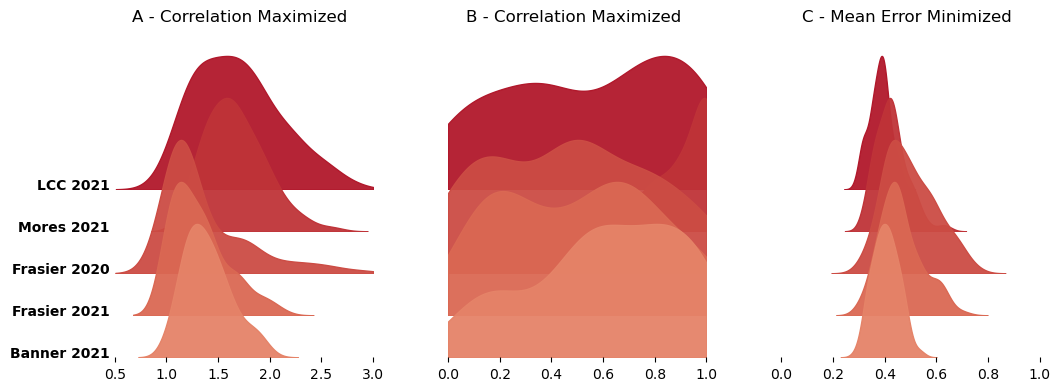

In [13]:
import matplotlib.gridspec as grid_spec
from matplotlib import colormaps
cmap = colormaps.get_cmap('RdBu')
colors = cmap(np.linspace(0.1, 0.4, len(ds.location)))

fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 3, wspace=0.07)
params = ['A', 'B', 'C']

loc_sorted = ['Little_Cottonwood_2021-03-18', 'Mores_2021-03-15',\
       'Frasier_2020-02-11','Frasier_2021-03-19', 'Banner_2021-03-15']  
       #,'Dry_Creek_2020-02-19', 'Cameron_2021-03-19',  'Mores_2020-02-09','Banner_2020-02-18',

sorted = ds.reindex(location = loc_sorted)

clips = [[0.5, 3], [0, 1], [0, 1]]

param_stat = {'A':'pearsonr', 'B':'pearsonr', 'C':'mae'}

for i, (param, subfig, clip,) in enumerate(zip(params, subfigs, clips)):
    axes = subfig.subplots(len(sorted.location), gridspec_kw = {'hspace': -0.7})
    other_params = params[:]
    other_params.remove(param)

    stat_name = param_stat[param]

    for loc, color, ax in zip(sorted.location, colors, axes):
        
        param_1, param_2 = other_params

        loc_ds = sorted.sel(location = loc)

        a = loc_ds.loc[{param_1 : loc_ds[param_stat[param_1]].idxmax(param_1)}]
        if param_2 == 'C':
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmin(param_2)}]
        else:
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmax(param_2)}]
        
        if param == 'C':
            data = data.idxmin(param)
        else:
            data = data.idxmax(param)
        
        data = data[param_stat[param]].data
        # data = data + np.random.random(data.shape)/1000

        sns.kdeplot(data, color = color, \
                    fill = True, alpha = 0.95, ax= ax, clip = clip, warn_singular=False, zorder = 1)
        ax.set_xlim(clip)
        ax.set_yticks([])
        ax.set_ylabel('')

        rect = ax.patch
        rect.set_alpha(0)

        spines = ["top", "right", "left", "bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)
        
        if i == 0:
            site_name = str(loc.data).replace('_', ' ').replace('Little Cottonwood', 'LCC').split('-')[0]
            ax.text(-0.02, 0, site_name, fontweight = 'bold', ha = 'right', transform = ax.transAxes, zorder = 1e5)


    for ax in axes[:-1]:
        ax.set_xticks([])

    stat_title= {'mae':'Mean Error Minimized', 'pearsonr':'Correlation Maximized'}
    subfig.suptitle(f'{param} - {stat_title[param_stat[param]]}')

plt.tight_layout()

plt.savefig(fig_dir.joinpath('ridgeplots_param_v1.png'))

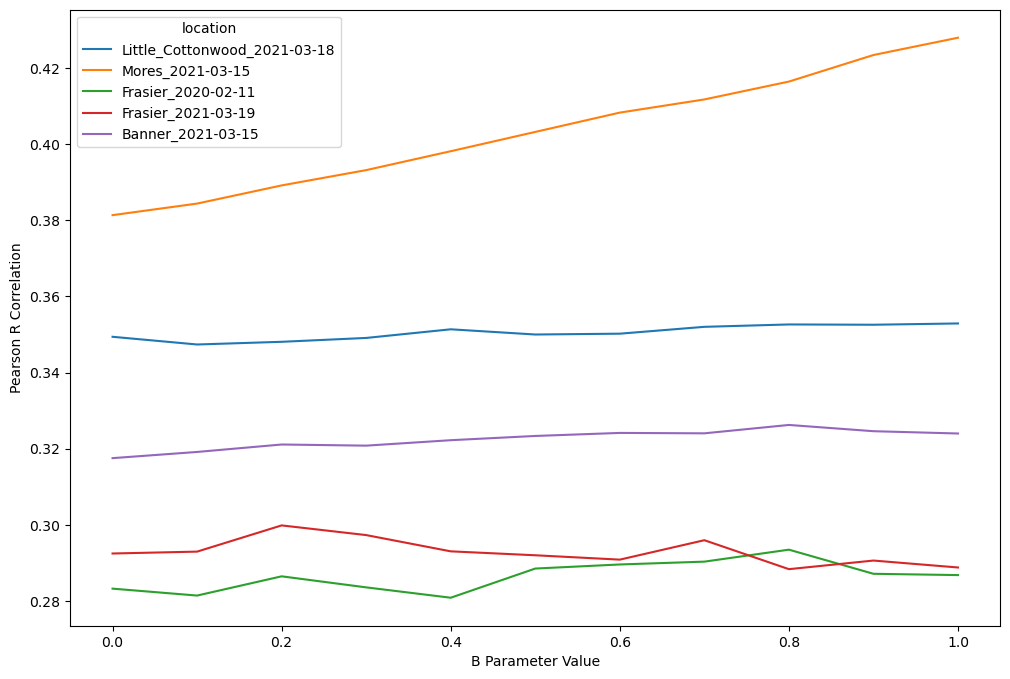

In [14]:
loc = ds.sel(location = loc_sorted)#.mean('iteration') # .isel(location = 8)

c_best = loc.sel(C = loc['mae'].idxmin('C'))
a_c_best = c_best.sel(A = c_best['pearsonr'].idxmax('A'))

min_ds = a_c_best.min('iteration')['pearsonr']
max_ds = a_c_best.max('iteration')['pearsonr']
mean_ds = a_c_best.mean('iteration')['pearsonr']

a_c_best['pearsonr'].mean('iteration').plot(hue = 'location', figsize = (12, 8))
plt.xlabel('B Parameter Value')
plt.ylabel('Pearson R Correlation')

# plt.legend(['Banner 2020', 'Banner 2021', 'Cameron 2021', 'Dry Creek 2020', 'Frasier 2020', 'Frasier 2021', 'LCC 2021', 'Mores 2020', 'Mores 2021'], loc = 'lower left')

# cmap = colormaps.get_cmap('RdBu')
# colors = cmap(np.linspace(0.1, 0.4, len(ds.location)))

# fig, ax = plt.subplots(figsize = (12, 8))

# for (loc, loc_ds), color in zip(min_ds.groupby('location'), colors):
#     ax.fill_between(loc_ds.B, loc_ds.data, max_ds.sel(location = loc).data, label = loc, color = color, alpha = 0.5)
#     ax.plot(loc_ds.B, mean_ds.sel(location = loc).data, color = color, zorder = 1e4)
# plt.legend()

# plt.xlabel('B Parameter Value')
# plt.ylabel('Pearson R Correlation')

plt.savefig(fig_dir.joinpath('b_pearson_affect.png'))

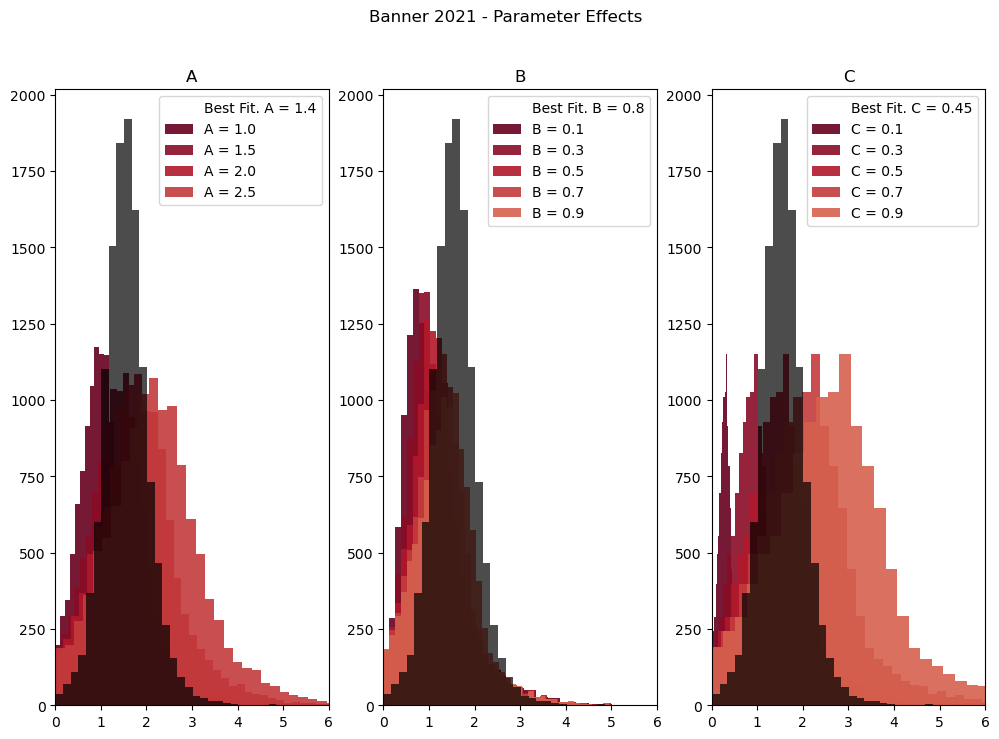

In [16]:
bins = 40
param_fp = Path('/bsuhome/zacharykeskinen/scratch/spicy/param_npys/')
for (loc, loc_ds) in ds.groupby('location'):
    if 'Banner_2021' not in loc:
        continue

    fig, axes = plt.subplots(1, 3, figsize = (12, 8))

    for param, pr, ax in zip(['A', 'B', 'C'], [(1,3, 0.5), (0.1, 1, 0.2), (0.1, 1, 0.2)], axes):

            trees = np.load(param_fp.joinpath(loc, f"trees.npy"))
            elev = np.load(param_fp.joinpath(loc, f"elev.npy"))
            idx = (trees < 0.8) & (elev > 2000) & (~np.isnan(trees)) & (~np.isnan(elev))

            lidar_sd = np.load(param_fp.joinpath(loc, f"lidar.npy"))[idx]

            ax.hist(lidar_sd, bins = bins, alpha = 0.7, color = 'black', zorder = 1e5)

            it = loc_ds.mean('iteration')
            a = it.sel(A = it['pearsonr'].idxmax('A')) 
            ab = a.sel(B = a['pearsonr'].idxmax('B'))
            abc = ab.sel(C = ab['mae'].idxmin('C'))
            
            best_params = {'A':abc.A.data, 'B': abc.B.data, 'C': abc.C.data}

            f = param_fp.joinpath(loc, f"{best_params['A']}_{best_params['B']}_{best_params['C']}.npy")
            spicy_sd = np.load(f)[idx]
            ax.hist(spicy_sd[spicy_sd > 0], bins = bins, label = f'Best Fit. {param.capitalize()} = {best_params[param]}', color = 'red', alpha = 0)
            
            for i, c in enumerate(np.round(np.arange(pr[0], pr[1], pr[2]), 2)):
                best_params[param] = c
                f = param_fp.joinpath(loc, f"{float(best_params['A']):.2}_{best_params['B']}_{best_params['C']}.npy")
                spicy_sd = np.load(f)[idx]
                ax.hist(spicy_sd[spicy_sd > 0], bins = bins, label = f'{param.capitalize()} = {c}', color = cmap(i / 20), alpha = 0.9)

            ax.set_title(param.capitalize())
            ax.legend()
            ax.set_xlim(0, 6)
plt.suptitle('Banner 2021 - Parameter Effects')

plt.savefig(fig_dir.joinpath('hists_params_banner.png'))

In [10]:
data_fp = Path('~/scratch/spicy/SnowEx-Data')

stat_res = pd.DataFrame()
for (loc, loc_ds) in ds.groupby('location'):
    it = loc_ds.mean('iteration')
    a = it.sel(A = it['pearsonr'].idxmax('A')) 
    ab = a.sel(B = a['pearsonr'].idxmax('B'))
    abc = ab.sel(C = ab['mae'].idxmin('C'))
    
    bp = {'A':abc.A.data, 'B': abc.B.data, 'C': abc.C.data}

    best = it.sel(A = bp['A'], B = bp['B'], C = bp['C'])

    for param_name, value in bp.items():
        stat_res.loc[loc, param_name] = value
    
    for param_name, value in best.items():
        stat_res.loc[loc, param_name] = value

    data_ds = xr.open_dataset(data_fp.joinpath(loc + '.nc'))

    for var in ['fcf', 'lidar-sd', 'lidar-vh', 'lidar-dem']:
        stat_res.loc[loc, var] = data_ds[var].mean().data

In [7]:
stat_res = pd.read_csv('/bsuhome/zacharykeskinen/spicy-analysis/results/params/stat_res_0.5tree.csv', index_col = 0)

In [9]:
loc = 'Banner_2020-02-18'

In [15]:
pd.DataFrame().size

0

In [11]:
list(stat_res.loc[loc, ['A','B', 'C']])

[1.1, 0.0, 0.75]

In [22]:
import shapely
from pathlib import Path
import pandas as pd
import xarray as xr
import rioxarray as rxa
from datetime import datetime

from spicy_snow.retrieval import retrieve_snow_depth

from spicy_snow.download.snowex_lidar import download_dem, download_snow_depth,\
      download_veg_height

from spicy_snow.IO.user_dates import get_input_dates


lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/spicy/lidar')

sites = {'USCOCP': 'Cameron', 'USCOFR': 'Frasier', 'USIDBS': 'Banner', 
         'USIDDC': 'Dry_Creek', 'USIDMC': 'Mores', 'USUTLC': 'Little_Cottonwood'}

def make_site_ds(site: str, lidar_dir: Path) -> xr.Dataset:
    """
    Makes a dataset of snow depth, veg height, and DEM for a specific site abbreviation
    in the lidar directory. Returns it reprojected to EPSG4326.

    Args:
    site: Site abbreviation to search for
    lidar_dir: Direction of lidar tiffs

    Returns:
    dataset: xarray dataset of dem, sd, vh for site
    """

    dataset = xr.Dataset()

    for img_type in ['SD', 'VH', 'DEM']:
        # files = glob(join(lidar_dir, f'*_{img_type}_*_{site}_*.tif'))
        files = lidar_dir.glob(f'*_{img_type}_*_{site}_*.tif')
        assert files, f"No files found for {img_type} at {site}"
        
        imgs = []
        for f in files:
            print(f)

            if img_type != 'DEM':
                date = pd.to_datetime(f.stem.split('_')[-2])
                sd_date = date
            else:
                date = sd_date

            img = rxa.open_rasterio(f)

            img = img.squeeze(dim = 'band')
            
            if img_type != 'DEM':
                img = img.expand_dims(time = [date])

            imgs.append(img)
        
        if img_type != 'DEM':
            dataset['lidar-' + img_type.lower()] = xr.concat(imgs, dim = 'time')
        else:
            dataset['lidar-' + img_type.lower()] = imgs[0]

    dataset = dataset.rio.reproject('EPSG:4326')
    
    return dataset

param_set = Path('/bsuhome/zacharykeskinen/spicy-analysis/results/params/stat_res_0.5tree.csv')
param_df = pd.DataFrame()
if param_set.exists():
    param_df = pd.read_csv(param_set, index_col = 0)

for site, site_name in sites.items():
    print(''.center(40, '-'))
    print(f'Starting {site_name}')

    lidar_ds_site = make_site_ds(site, lidar_dir = lidar_dir)

    lidar_ds_site = lidar_ds_site.where(lidar_ds_site < 1e9).where(lidar_ds_site >= 0)

    area = shapely.geometry.box(*lidar_ds_site.rio.bounds())

    for date in lidar_ds_site.time:

        if param_df.size > 0:
            out_dir = Path('/bsuhome/zacharykeskinen/scratch/spicy/SnowEx-Data-params/')
        else:
            out_dir = Path('/bsuhome/zacharykeskinen/scratch/spicy/SnowEx-Data/')
        
        out_nc = out_dir.joinpath(f'{site_name}_{(date).dt.strftime("%Y-%m-%d").values}.nc')

        out_dir.mkdir(exist_ok = True)
        if out_nc.exists():
            print(f'Outfile {out_nc} exists already.')
            continue

        print(f'Starting {site_name} snow depth @ {date.values}')

        if date.dt.month > 4:
            continue

        lidar_ds = lidar_ds_site.sel(time = date)

        dates = get_input_dates(date.data + pd.Timedelta('14 day'))

        # if param_df.size > 0:
        #     spicy_ds = retrieve_snow_depth(area = area, dates = dates, work_dir = '/bsuhome/zacharykeskinen/scratch/spicy/', \
        #                                    job_name = f'spicy_{site}_{dates[1]}', existing_job_name = f'spicy_{site}_{dates[1]}'\
        #                                     params = list(param_df.loc[loc, ['A','B', 'C']]))
        # else:    
        #     spicy_ds = retrieve_snow_depth(area = area, dates = dates, work_dir = '/bsuhome/zacharykeskinen/scratch/spicy/', job_name = f'spicy_{site}_{dates[1]}', existing_job_name = f'spicy_{site}_{dates[1]}')

        # lidar_ds = lidar_ds.rio.reproject_match(spicy_ds)

        # ds = xr.merge([spicy_ds, lidar_ds], combine_attrs = 'drop_conflicts')

        # # ds = ds[['lidar-sd', 'lidar-vh', 'lidar-dem', 'snow_depth', 's1', 'wet_snow']]

        # ds.attrs['site'] = site_name
        # ds.attrs['site_abbrev'] = site
        # ds.attrs['lidar-flight-time'] = str((date).dt.strftime("%Y-%m-%d").values)
        # ds.attrs['processing-date'] = f'{datetime.now()}'
        
        # try:
        #     ds.to_netcdf(out_nc)
        # except:
        #     print('Unable to create netcdf4 for {site_name}')

----------------------------------------
Starting Cameron
/bsuhome/zacharykeskinen/scratch/spicy/lidar/SNEX20_QSI_SD_0.5M_USCOCP_20210319_20210319.tif
/bsuhome/zacharykeskinen/scratch/spicy/lidar/SNEX20_QSI_VH_0.5M_USCOCP_20210319_20210319.tif
/bsuhome/zacharykeskinen/scratch/spicy/lidar/SNEX20_QSI_DEM_0.5M_USCOCP_20210918_20210918.tif
Starting Cameron snow depth @ 2021-03-19T00:00:00.000000000
----------------------------------------
Starting Frasier
/bsuhome/zacharykeskinen/scratch/spicy/lidar/SNEX20_QSI_SD_0.5M_USCOFR_20210319_20210320.tif


KeyboardInterrupt: 

In [23]:
list(param_df.loc[out_nc.stem, ['A','B', 'C']])

[2.1, 0.0, 0.52]

In [17]:
param_df

,A,B,C,pearsonr,mae,rmse,bias,fcf,lidar-sd,lidar-vh,lidar-dem
Banner_2020-02-18,1.1,0.0,0.75,0.216773,0.855290,1.054661,-0.400697,0.499315,1.511063,2.754594,2285.490234
Banner_2021-03-15,1.4,0.8,0.45,0.305791,0.695729,0.891767,-0.260183,0.497261,1.489487,3.075213,2285.475830
Cameron_2021-03-19,2.1,0.0,0.52,0.131518,0.823115,1.075871,-0.343825,0.481719,1.453631,3.701234,3212.908691
Dry_Creek_2020-02-19,1.0,0.2,0.77,-0.004410,0.687821,0.835796,-0.392769,0.597624,1.048450,4.988070,1832.537109
Frasier_2020-02-11,1.1,0.8,0.71,0.203106,0.806307,1.090825,-0.334541,0.658363,1.109154,4.588181,3091.379639
Frasier_2021-03-19,1.1,0.6,0.56,0.236738,0.543980,0.773427,-0.284324,0.660943,0.865026,5.102107,3091.115479
Little_Cottonwood_2021-03-18,1.8,1.0,0.42,0.309580,0.947107,1.181658,-0.405660,0.229028,1.822454,1.499236,2945.443359
Mores_2020-02-09,1.0,0.1,0.96,0.001342,0.890716,1.086224,-0.453291,0.485023,1.798374,2.784396,2087.048584
Mores_2021-03-15,1.8,1.0,0.45,0.389919,0.745273,0.906681,-0.446094,0.486107,1.607694,3.500407,2086.010986
